In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list

#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

# Import my own functions
from desc.fns_simp import (#data_eval, 
                           #_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           #plot_xy,
                           #surf_int
                          )

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory

In [3]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization_fd,
    CoilThicknessRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [4]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [5]:
G_QA = eq_QA.compute("G")["G"][-1] / mu_0 * 2*np.pi
G_QH = eq_QH.compute("G")["G"][-1] / mu_0 * 2*np.pi

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [6]:
eq = eq_QH

#surf_name = "/home/fcastro/DESC/docs/notebooks/R_Opt_old/opt7/surf_opt.h5"
surf_name = "surf_opt.h5"
surf = load(surf_name)

In [7]:
surf1 = surf

#surf1.change_resolution(M=8,N=6)

#surf1.change_resolution(M=4,N=4)

# Generate a Surface Current field for RQA
#surf2 = FourierCurrentPotentialField.from_surface(surf,
#                                                  M_Phi=12,
#                                                  N_Phi=12,
                                                  #sym_Phi=True, 
                                                  #I=0, 
                                                  #G=G_QA
#                                                 )

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
#surf2.G = G_QH

In [8]:
#surf2.G = np.load('G.npy')
#surf2.I = np.load('I.npy')
#surf2.Phi_mn = np.load('phi_mn.npy')

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

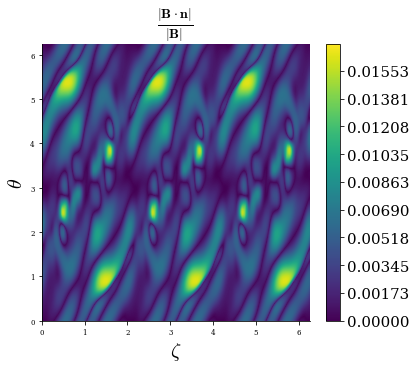

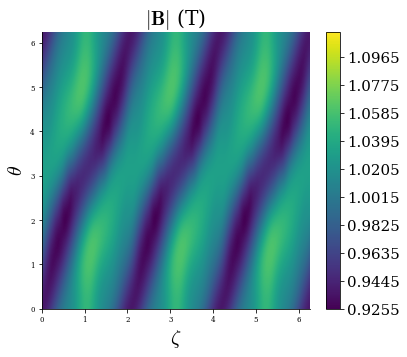

In [9]:
# Find B on plasma surface
egrid = LinearGrid(M = 100, N = 100)

coords = eq.compute(["R", "phi", "Z"], grid = egrid)

n_rho = eq.compute("n_rho", grid = egrid)["n_rho"]

#B = coords["B"]
coords = np.vstack([coords["R"], coords["phi"], coords["Z"]]).T

# surface_current_field.compute_magnetic_field actually computes the normal field only
B_from_surf = surf2.compute_magnetic_field(coords,)# grid=egrid)

# Plot B on the plasma surface
mag_B = jnp.sqrt(dot(B_from_surf,B_from_surf))

Bn = abs(dot(B_from_surf,n_rho))*mag_B**(-1) 

plot_figure(Bn,egrid,''r'$\frac{|\mathbf{B} \cdot \mathbf{n}|}{|\mathbf{B}|}$')
plot_figure(mag_B,egrid,''r'$|\mathbf{B}|$ (T)')

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

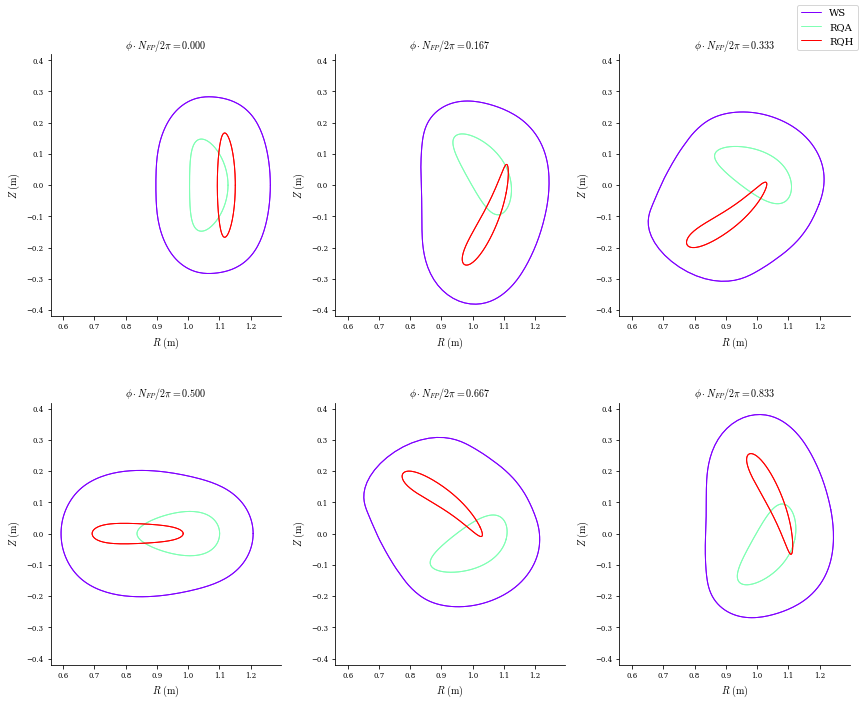

In [10]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [11]:
surf2.I

6657954.097956844

In [12]:
surf2.Phi_mn

array([ 1.60180151e+01, -1.28874755e+01, -3.18175707e+01,  2.83207207e+01,
        1.03843358e+01, -4.23486380e+01,  6.45747596e+01, -6.50844026e+01,
        4.14482469e+01, -1.04566702e+01, -8.93807747e-01,  7.88659940e+00,
       -3.01487974e+00,  2.24496461e+01,  3.89856112e+00, -4.35053059e+01,
        1.79358902e+02, -1.29319509e+02,  7.52630264e+01, -4.06710983e+01,
        3.68032894e+01, -3.15026501e+01,  8.42360687e+01, -7.59253584e+01,
        3.87252696e+01,  2.87869841e+01,  1.71677660e+02, -2.12248888e+02,
       -1.50300741e+01,  1.90935553e+02, -4.42727286e+01, -1.35875054e+02,
        1.54958486e+02, -2.30630054e+02,  1.12423384e+02,  4.94083700e+01,
       -1.01507543e+01, -3.02221529e+01,  7.87979809e+01, -6.59585954e+01,
       -1.55752004e+00, -2.05579803e+02, -1.26685893e+01,  1.26117467e+02,
       -1.34448104e+02, -1.76423485e+02,  1.19631087e+02, -1.03288603e+02,
        8.94084344e+01, -1.77942466e+01,  7.15589603e+00,  2.12239461e+01,
       -1.46888186e+03,  

In [13]:
surf2.NFP

3

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Text(0.5, 1.0, 'K surf2')

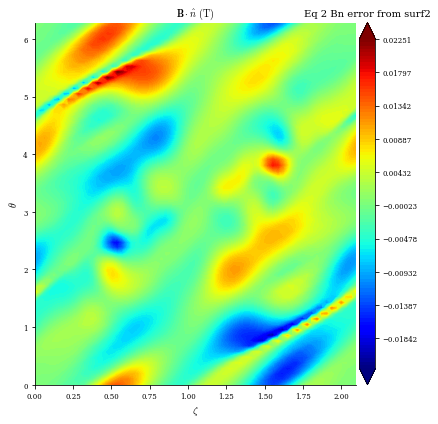

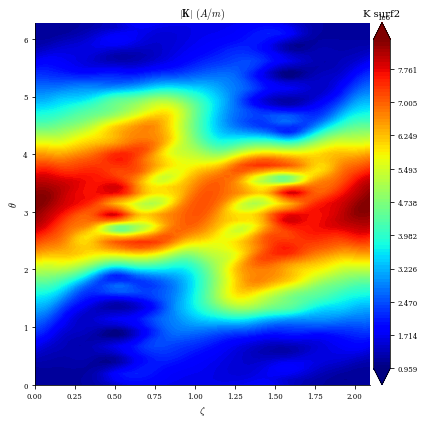

In [14]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=60,N=60,
                                NFP=eq_QH.NFP
                               )

plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")

plot_2d(surf2, "K")
plt.title("K surf2")

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

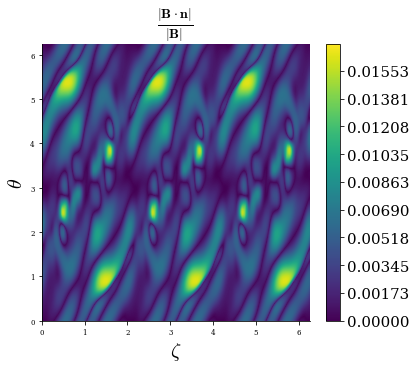

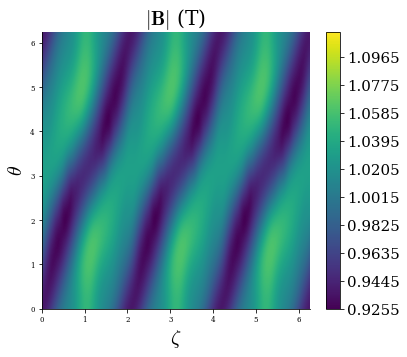

In [15]:
# Find B on plasma surface
egrid = LinearGrid(M = 100, N = 100)

coords = eq.compute(["R", "phi", "Z"], grid = egrid)

n_rho = eq.compute("n_rho", grid = egrid)["n_rho"]

#B = coords["B"]
coords = np.vstack([coords["R"], coords["phi"], coords["Z"]]).T

# surface_current_field.compute_magnetic_field actually computes the normal field only
B_from_surf = surf2.compute_magnetic_field(coords,)# grid=egrid)

# Plot B on the plasma surface
mag_B = jnp.sqrt(dot(B_from_surf,B_from_surf))

Bn = abs(dot(B_from_surf,n_rho))*mag_B**(-1) 

plot_figure(Bn,egrid,''r'$\frac{|\mathbf{B} \cdot \mathbf{n}|}{|\mathbf{B}|}$')
plot_figure(mag_B,egrid,''r'$|\mathbf{B}|$ (T)')

In [16]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [17]:
# Grids
Megrid = 10
Negrid = 10

Msgrid = 30
Nsgrid = 15

egrid = LinearGrid(M=Megrid,N=Negrid,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   NFP=eq.NFP,
                   sym=False) 

In [18]:
surf1.NFP

3

In [19]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn

In [20]:
flux_QA = QuadraticFlux(eq_QA,
                        surf1,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 1e0,
                        name="Bn error  eq_QA")

flux_QH = QuadraticFlux(eq_QH,
                        surf2,
                        field_grid=sgrid,
                        eval_grid=egrid,
                        vacuum=True,
                        weight = 1e0,
                        name="Bn error  eq_QH")

In [21]:
# Distance target
min_QA = 0.1
max_QA = 0.3

min_QH = 0.1
max_QH = 0.25#1#0.28

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf1,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 10,
    #use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf2,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    #use_signed_distance=True,
    weight = 20,
    name="distance error  RQH"
)

In [22]:
surf_curr_reg_QA = SurfaceCurrentRegularization(
    surf1,
    #target=None,
    #bounds=None,
    weight=1e0,
    #normalize=True,
    #normalize_target=True,
    #loss_function=None,
    #deriv_mode="auto",
    source_grid=sgrid,
    name="surface-current-regularization QA",
    )

surf_curr_reg_QH = SurfaceCurrentRegularization(
    surf2,
    #target=None,
    #bounds=None,
    weight=1e0,
    #normalize=True,
    #normalize_target=True,
    #loss_function=None,
    #deriv_mode="auto",
    source_grid=sgrid,
    name="surface-current-regularization QA",
    )

In [23]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf1,
    #target = mean_curv,
    bounds = (-1,1),
    weight=1e-2,
    normalize=True,
    normalize_target=True,
    deriv_mode="auto",
    grid=sgrid,
    name="Mean curvature",
)

In [24]:
obj_prin_curv = PrincipalCurvature(surf1,
        #target=None,
        bounds=(-15,-10),
        weight=2e0,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [25]:
Jmax = 5e7 # max current density 50 MA/m2
tmax = 1.5e-1 # max thickness desired for coils: 10 cm

obj_thickness_QA = bRegularization_fd(surf1,
                                               #target=None,
                                               bounds = (0,Jmax*tmax),
                                               weight = 2e-6,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QA",
                                              )

obj_thickness_QH = bRegularization_fd(surf2,
                                               #target=None,
                                               bounds = (0,Jmax*tmax),
                                               weight = 1e0,
                                               #normalize=True,
                                               #normalize_target=True,
                                               #loss_function=None,
                                               deriv_mode="auto",
                                               source_grid = sgrid,
                                               name = "Coil Thickness Regularization: QH",
                                              )

In [26]:
obj = ObjectiveFunction((#flux_QA,
                         flux_QH,
                         #obj_dist_QA,
                         #obj_dist_QH,
                         #obj_mean_curv,
                         #obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         #obj_thickness_QA,
                         obj_thickness_QH,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    #FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    FixParameters(surf2,{"R_lmn":True, "Z_lmn":True,
                         "G":True,}
                 ),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    #ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [27]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [28]:
# Run optimization
res,_ = opt.optimize(surf2, 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=10,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 #options={"initial_trust_radius":np.inf}
                      )

surf2 = res[0]

Building objective: Bn error  eq_QH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 1.08 sec

Building objective: Coil Thickness Regularization: QH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 321 ms

Timer: Objective build = 1.81 sec

Building objective: fixed parameters

Timer: Objective build = 232 ms

Timer: Linear constraint projection build = 1.31 sec

Number of parameters: 313

Number of objectives: 2332

Timer: Initializing the optimization = 3.44 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          1.449e+16                                    1.841e+17   

       1              3          4.139e+15      1.035e+16      1.353e+03      1.431e+17   

       2              5          2.211e+15      1.928e+15      3.908e+02      6.803e+16   

       3              7          1.142e+15      1.069e+15      1.002e+02      1.703e+17   

       4              9          1.057e+15      8.546e+13      1.941e+01      9.477e+16   

       5             10          9.753e+14      8.143e+13      7.021e+00      9.110e+16   

       6             12          9.429e+14      3.236e+13      3.514e+00      8.799e+16   

       7             15          9.384e+14      4.475e+12      3.557e-01      8.925e+16   

       8             17          9.375e+14      9.641e+11      1.104e-01      8.740e+16   

       9             20          9.373e+14      1.412e+11      1.111e-02      8.919e+16   

      10             22          9.373e+14      2.841e+10      3.451e-03      8.738e+16   

         Current function value: 9.373e+14

         Total delta_x: 1.399e+03

         Iterations: 10

         Function evaluations: 22

         Jacobian evaluations: 11

Timer: Solution time = 52.7 sec

Timer: Avg time per step = 4.79 sec

                                                                 Start  -->   End

Total (sum of squares):                                      1.449e+16  -->   9.373e+14, 

Maximum absolute Boundary normal field error:                3.592e-03  -->   1.917e-02 (T m^2)

Minimum absolute Boundary normal field error:                2.416e-16  -->   1.109e-16 (T m^2)

Average absolute Boundary normal field error:                3.994e-04  -->   4.850e-03 (T m^2)

Maximum absolute Boundary normal field error:                6.304e-02  -->   3.364e-01 (normalized)

Minimum absolute Boundary normal field error:                4.240e-15  -->   1.946e-15 (normalized)

Average absolute Boundary normal field error:                7.008e-03  -->   8.511e-02 (normalized)

Maximum Sigma Regularization:                                2.206e+07  -->   1.147e+07 

Minimum Sigma Regularization:                                4.929e+06  -->   3.895e+06 

Average Sigma Regularization:                                1.056e+07  -->   7.774e+06 

Maximum Sigma Regularization:                                2.206e+07  -->   1.147e+07 (normalized)

Minimum Sigma Regularization:                                4.929e+06  -->   3.895e+06 (normalized)

Average Sigma Regularization:                                1.056e+07  -->   7.774e+06 (normalized)

Fixed parameters error:                                      0.000e+00  -->   9.313e-10 (~)

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

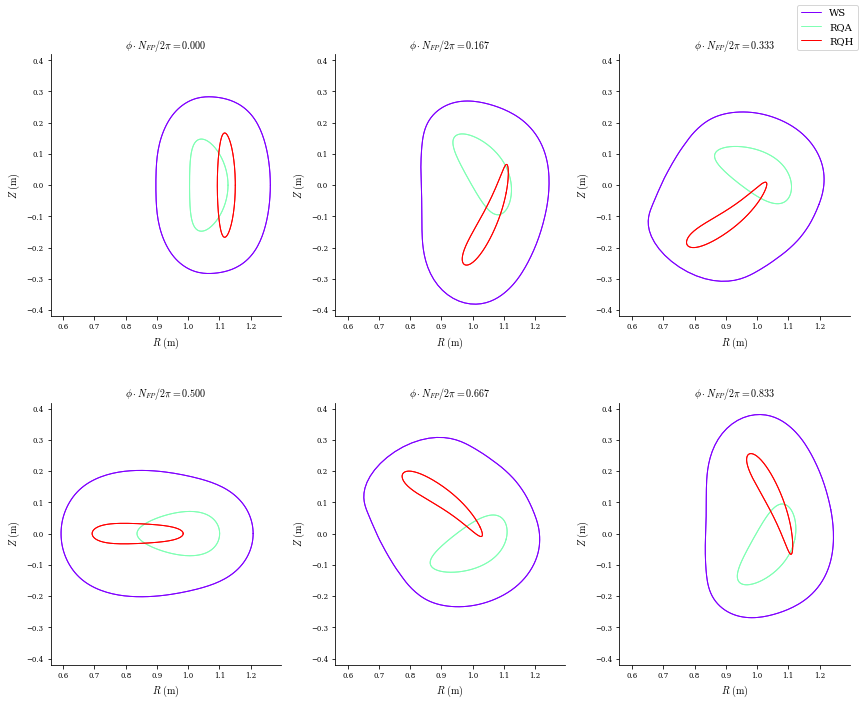

In [29]:
plot_comparison([surf2,
                 eq_QA,
                 eq_QH
                ],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [30]:
#surf1.save("surf_opt.h5")

In [31]:
#surf1.I

In [32]:
surf2.I

6717889.11527695

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

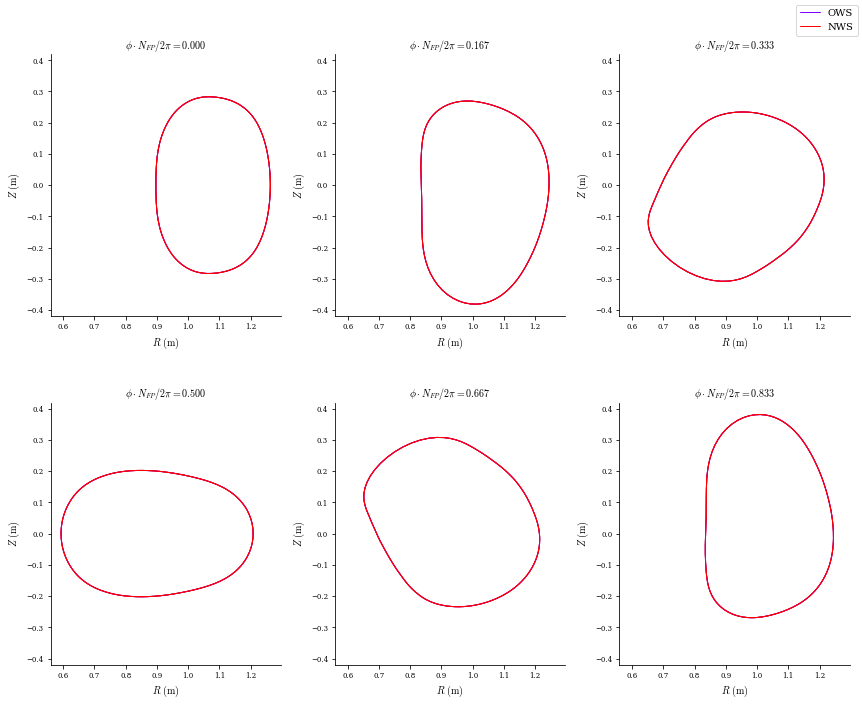

In [33]:
plot_comparison([surf,surf1],
                labels=["OWS","NWS"],
                theta=0,rho=np.array(1.0)
               )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Text(0.5, 1.0, 'K surf2')

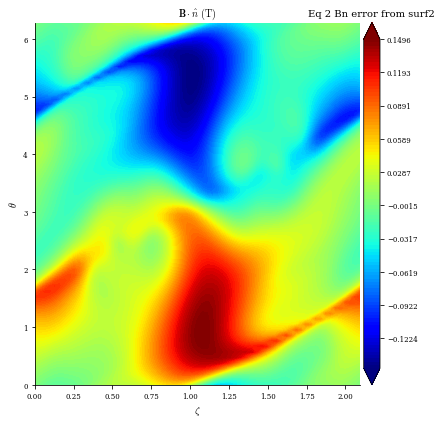

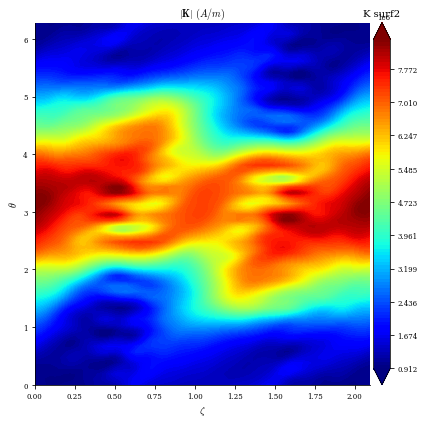

In [34]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=60,N=60,
                                NFP=eq_QH.NFP
                               )
#plot_2d(eq_QA,"B*n",field=surf1, field_grid=denser_source_grid)
#plt.title("Eq 1 Bn error from surf1")

#plot_2d(surf1, "K")
#plt.title("K surf1")

plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")

plot_2d(surf2, "K")
plt.title("K surf2")

In [35]:
#b_QA = surf1.compute("b_s",grid = denser_source_grid)["b_s"]

#plot_figure2(b_QA,
#            denser_source_grid,
#            ''r'$b_{QA}$ '
#           )

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

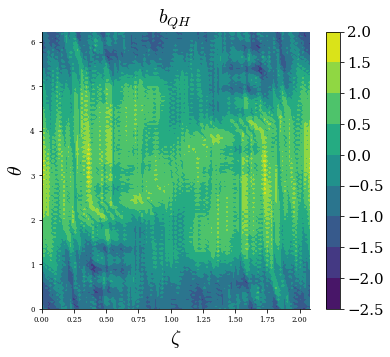

In [36]:
b_QH = surf2.compute("b_s",grid = denser_source_grid)["b_s"]

plot_figure2(b_QH,
            denser_source_grid,
            ''r'$b_{QH}$ '
           )

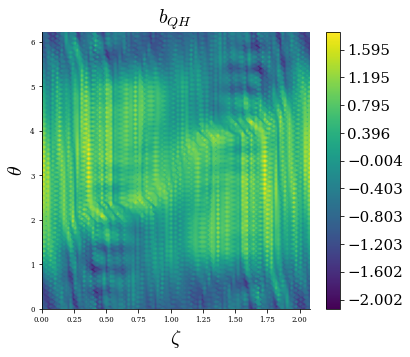

In [37]:
plot_figure(b_QH,
            denser_source_grid,
            ''r'$b_{QH}$ '
           )